# Exploratory Data Analysis - Customer loans in finance 

## Accessing the data 

Importing files and modules needed to access and manipulate the data given within this notebook

In [6]:
import db_utils
import dfInfo_class
import df_transforms
import plotter_class
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import scipy
import seaborn as sns
import yaml
pio.renderers.default = "notebook"

Using the 'RDSDatabaseConnector' class to initialise the database and load into a CSV file

In [7]:
with open('credentials.yaml') as file:
    credentials_dict = yaml.safe_load(file)
    
credentials = db_utils.RDSDatabaseConnector(credentials_dict)
loan_payments = credentials.initialise_database()
credentials.save_file(loan_payments, 'new_file.csv')

database = credentials.load_csv('new_file.csv')


Printing the first 10 rows of the database so that we can see all of the database columns as well as the information each column contains

In [ ]:
database.head(10)

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
5,38656111,41439917,2525,2525.0,2525.0,36 months,11.44,83.20,B,B4,...,0.0,0.0,Jan-2022,91.39,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
6,38656110,41439916,6675,6675.0,6675.0,NaN,21.99,254.89,E,E5,...,0.0,0.0,Mar-2021,6724.95,NaN,Mar-2021,0.0,NaN,1,INDIVIDUAL
7,38656067,41439872,26500,26500.0,26200.0,NaN,19.99,701.95,E,E3,...,0.0,0.0,Aug-2021,701.95,NaN,Jan-2022,0.0,43.0,1,INDIVIDUAL
8,38656063,41439868,10000,10000.0,10000.0,60 months,12.99,227.48,C,C2,...,0.0,0.0,Jan-2022,227.48,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
9,38656052,41439857,10000,NaN,10000.0,36 months,8.19,314.25,A,A5,...,0.0,0.0,Jan-2022,314.25,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


Initialising 'DataFrameInfo' class so that we can print out information about the dataframe

In [ ]:
df_info = dfInfo_class.DataFrameInfo(database)

Printing information about the dataframe

In [ ]:
print(df_info.info())

Printing the shape of the dataframe

In [ ]:
print(df_info.shape())

Printing out the column names and the amount of unique values it contains

In [ ]:
for col in database.columns:
    print(f'{col}:      {len(df_info.unique_vals)}')

Splitting the columns into the type of data it contains

In [ ]:
fixed_data = ['id','member_id']

date_data = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']

categorical_data = ['term', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 
                    'loan_status', 'payment_plan', 'purpose', 'policy_code', 'application_type']

non_numeric_data = date_data + categorical_data + fixed_data
numeric_data = [data_column for data_column in database.columns if data_column not in non_numeric_data]


Initialising the 'DataTransform' class so that we can transform the columns of the dataframe into the correct dtype.

In [ ]:
data_transform = df_transforms.DataTransform(database)

Changing the dtypes of the columns which consists of only date data and ones that only consist of categories

In [ ]:
for date_column in date_data:
    data_transform.date_data(date_column)

for categories in categorical_data:
    data_transform.change_type(categories, 'category')

In [ ]:
#   Dropping columns with mostly null values and filling in missing values

df_transform = df_transforms.DataFrameTransform(database)

for column in database.columns:
    null_vals, null_percentage = df_info.missing(column)
    if null_percentage > float(50):
        database.drop(column, axis=1, inplace=True)

database['funded_amount'] = database['loan_amount']

fill_values = {'collections_12_mths_ex_med': 0, 'term': database['term'].mode()[0], 'int_rate': database['int_rate'].mean}
df_transform.fill_null(values= fill_values)

for index in range(df_info.df_shape()[0]):
    if database.loc[index, 'collections_12_mths_ex_med'] == 0 and database.loc[index, 'last_payment_date'] != 'NaT':
        database.loc[index, 'collections_12_mths_ex_med'] += 1

    if database.loc[index, 'last_payment_date'] == 0:
        database.loc[index, 'last_payment_date'] = database.loc[index, 'last_credit_pull_date']

    if database.loc[index, 'last_credit_pull_date'] == 0:
        database.loc[index, 'last_credit_pull_date'] = database.loc[index, 'last_payment_date']

database.dropna(subset=['employment_length'], inplace=True)

#   Removing highly skewed data

new_database = database.copy()
df2_transform = db_utils.DataFrameTransform(new_database)

original_skews = df_info.df_skew(database)

skewed_data = database[[cols for cols, skews in original_skews.items() if skews > 2]]
log_skewed_data = yeojohnson_skew = boxcox_skew = skewed_data.copy()

log_skewed_data = df2_transform.log_transform(log_skewed_data)
yeojohnson_skew = df2_transform.yeojohnson_transform(yeojohnson_skew)
boxcox_skew = df2_transform.boxcox_transform(boxcox_skew)

log_skew = df_info.df_skew(log_skewed_data)
yeo_skew = df_info.df_skew(yeojohnson_skew)
box_skew = df_info.df_skew(boxcox_skew)

for column, col_vals in skewed_data.items():

    col_skew = abs(original_skews.get(column))

    log_col_skew = abs(log_skew[column])
    yeo_col_skew = abs(yeo_skew[column])
    
    smallest_skew = min(log_col_skew, yeo_col_skew, col_skew)
    
    if column in boxcox_skew.columns:
        box_col_skew = abs(box_skew[column])
    
        if box_col_skew <= smallest_skew:
            new_database[column] = boxcox_skew.loc[:, column]

    if smallest_skew == log_col_skew or smallest_skew == log_col_skew == yeo_col_skew:
        new_database[column] = log_skewed_data.loc[:, column]
    elif smallest_skew == yeo_col_skew:
        new_database[column] = yeojohnson_skew.loc[:, column]

#   Initialising the 'Plotter' variable so that we can plot various graphs

df_plot = plotter_class.Plotter(new_database)

#   Finding and removing outliers in the data.

df2_transform.remove_outliers()

#   Removing extremely highly correlated columns in the dataframe

data_corr_matrix = new_database.corr(numeric_only = True).abs()
upper = data_corr_matrix.where(np.triu(np.ones(data_corr_matrix.shape), k=1).astype(bool))
to_drop = [database_col for database_col in upper.columns if any(upper[database_col] > 0.95)]
new_database.drop(to_drop, axis=1, inplace=True)

In [ ]:
''' 
Finding the amount of loans recovered and visualising the results.
'''

recovered_payments = unrecovered_payments = 0

for element in new_database['out_prncp']:
    if element > 0:
        unrecovered_payments += 1
    else:
        recovered_payments += 1

### Plotting a pie chart of the amount of recovered and unrecovered loans

df_plot.plot_pie([unrecovered_payments, recovered_payments], ['Unrecovered payments', 'Recovered payments'], 'The amount of loans recovered against the investor funding and the total amount funded')

In [ ]:
'''
Visualising and finding the percentage of the total amount that would be recovered up to 6 months' in the future.
'''

for position, member in new_database.iterrows():
    if member['loan_status'] in ['Current', 'In Grace Period']:
        outstanding_principle = member['out_prncp']
        instalment = member['instalment']

        recovered_6months = 6 * instalment

        if recovered_6months > outstanding_principle:
            unrecovered_payments -= 1
            recovered_payments += 1

### Plotting a pie chart to show how much of the payments would be recovered up to 6 months in the future

df_plot.plot_pie([unrecovered_payments, recovered_payments], ['Unrecovered payments up to 6 months in the future', 'Recovered payments up to 6 months in the future'], 'The amount of loans recovered against the investor funding and the total amount funded')

In [ ]:
'''
Calculating the percentage of loans that have been a loss (i.e. charged off)
and the total amount that was paid towards these loans before being charged off.

Calculating the loss in revenue these loans would have generated for the company if they had finished 
their term and visualising the loss projected over the remaining term of these loans.
''' 

charged_off_loans = charged_off_total_paid = revenue_lost = 0
term_int_column = new_database['term'].astype('str').map(pd.Series({'36 months': 36, '60 months': 60}))
charged_off_members = []

projected_losses = {}

for index, row in new_database.iterrows(): 
    if 'Charged Off' in row['loan_status'] or row['loan_status'] == 'Default':
 
        charged_off_loans += 1
        charged_off_members.append(row)
        loan_term = term_int_column[index]
        loan_instalment = row['instalment']
        total_paid = row['total_payment']


        charged_off_total_paid += total_paid
        payment_left = (loan_term * loan_instalment) - total_paid
        instalments_left = round(payment_left/loan_instalment)
        revenue_lost += payment_left
        projected_losses[index] = [round(i*loan_instalment,2) for i in range(instalments_left)]

charged_off_percentage = (charged_off_loans/df_info.df_shape()[0]) * 100

print(f"Percentage of loans charged off: {round(charged_off_percentage, 2)}%")
print(f"Amount paid to the loand prior to being charged off: £{round(charged_off_total_paid, 2):,}")
print(f"Loss in revenue: £{round(revenue_lost, 2):,}")

Percentage of loans charged off: 10.95%
Amount paid to the loand prior to being charged off: £38,282,801.65
Loss in revenue: £65,506,567.19


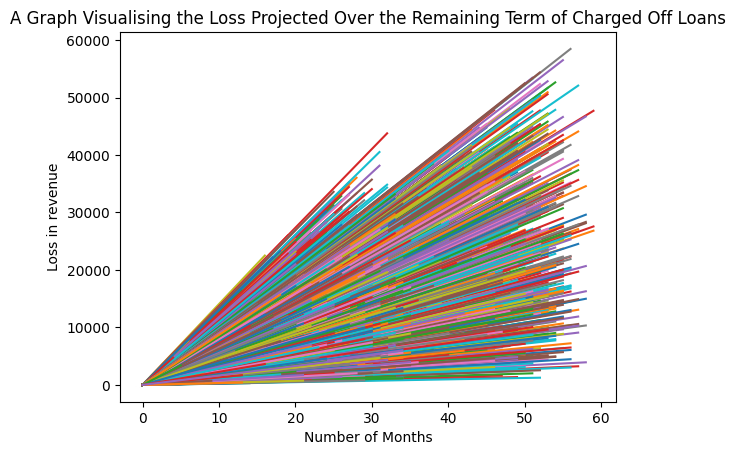

In [ ]:
### Plotting a graph of the loss projected over the remaining term of loans if they had finished their term

projected_loss_df = pd.DataFrame.from_dict(dict([ (member,pd.Series(loss)) for member, loss in projected_losses.items() ]))
ax = projected_loss_df.plot(title = 'A Graph Visualising the Loss Projected Over the Remaining Term of Charged Off Loans', 
                            xlabel= 'Number of Months', ylabel = 'Loss in revenue')
ax.get_legend().remove()

In [ ]:
'''
Finding the percentage of users who are currently behind with their loan payments and what they currently 
represent as a percentage of all loans. Calculating how much loss the company would incur if their status was 
changed to Charged Off. 

If customers late on payments converted to Charged Off, calculating the percentage of total expected revenue 
these customers and the customers who have already defaulted on their loan represent.
'''

late_members = []
late_payments = remaining_payments = total_payments = 0
late_payment_markers = ['Late (16-30 days)', 'In Grace Period', 'Late (31-120 days)']

for number, individual in new_database.iterrows():

    total_payments += individual['total_payment'] 

    if individual['loan_status'] in late_payment_markers:
        late_payments += 1
        late_members.append(individual)

        remaining_payments += individual['out_prncp'] 

total_loss = remaining_payments + revenue_lost
late_payment_percentage = (late_payments/df_info.df_shape()[0]) * 100
loss_percentage = (total_loss/total_payments) * 100

print(f"Number of late payments: {late_payments}")
print(f"Percentage of loan payments that are late: {round(late_payment_percentage, 2)}%")
print(f"Amount of loss if users with late loan payments were changed to Charged Off: £{round(remaining_payments,2)}")
print(f"Percentage of total expected revenue that late and charged off loans represent: {round(loss_percentage, 2)}%")

Number of late payments: 901
Percentage of loan payments that are late: 1.73%
Amount of loss if users with late loan payments were changed to Charged Off: £995.69
Percentage of total expected revenue that late and charged off loans represent: 10.31%


In [ ]:
'''
Analysing the data to visualise the possible indicators that a customer will not be able to pay the loan.
'''

charged_off_df = updated_charged_off_df = pd.DataFrame(charged_off_members).select_dtypes(exclude=['datetime64[ns]'])
late_df = updated_late_df = pd.DataFrame(late_members).select_dtypes(exclude=['datetime64[ns]'])

for col_title in categorical_data:
    for col_index in range(len(categorical_data)):
        crosstab = pd.crosstab([col_title], [categorical_data[col_index]])
        chi_val, p_val, degree, freqs = scipy.stats.chi2_contingency(crosstab)
        
        if p_val < 0.05:
            print(f"Colummns {col_title} and {categorical_data[col_index]} have a relationship.")

updated_charged_off_df = df2_transform.dummy_df(charged_off_df, updated_charged_off_df)
updated_late_df = df2_transform.dummy_df(late_df, updated_late_df)

charged_off_corr_matrix = df_info.check_correlation(updated_charged_off_df)
late_corr_matrix = df_info.check_correlation(updated_late_df)
np.seterr(divide='ignore', invalid='ignore')

charged_filter1 = charged_off_corr_matrix.abs() < 1
charged_filter2 = charged_off_corr_matrix.abs() > 0.6
late_filter1 = late_corr_matrix.abs() < 1
late_filter2 = late_corr_matrix.abs() > 0.6

charged_off_correlations = charged_off_corr_matrix.where(charged_filter1 & charged_filter2 & np.triu(np.ones((508,508)), k=1)).stack().sort_values()
late_correlations = late_corr_matrix.where(late_filter1 & late_filter2 & np.triu(np.ones((223,223)), k=1)).stack().sort_values()

unpaid_common_variables, late_variables, charged_off_variables = ([] for list_number in range(3))

for late_term, late_correlation in late_correlations.items():
    late_variables.append(late_term)
    for charged_term, charged_correlation in charged_off_correlations.items():
        charged_off_variables.append(charged_term)
        if set(late_term) == set(charged_term):
            unpaid_common_variables.append(late_term)

late_variables = list(set(late_variables))
charged_off_variables = list(set(charged_off_variables))

print('The following variables have a strong correlation for all unpaid loans:')
for unpaid_var in unpaid_common_variables:
    print(f"{unpaid_var[0]} and {unpaid_var[1]}")

print('\n\nThe following variables have a strong correlation for charged off loans:')
for charged_var in charged_off_variables:
    print(f"{charged_var[0]} and {charged_var[1]}") 

print('\n\nThe following variables have a strong correlation for late loans:')
for late_var in late_variables:
    print(f"{late_var[0]} and {late_var[1]}")

The following variables have a strong correlation for all unpaid loans:
MORTGAGE and RENT
open_accounts and total_accounts
A and A5
6.62 and A2
25.89 and G3
instalment and total_rec_int
7.9 and A4
loan_amount and total_payment
instalment and total_payment
loan_amount and total_rec_int
total_payment and total_rec_int
24.5 and F3
loan_amount and instalment
24.08 and F2


The following variables have a strong correlation for charged off loans:
36 months and 60 months
loan_amount and instalment
loan_amount and total_rec_int
A and A5
total_payment and total_rec_int
out_prncp and Default
instalment and total_rec_int
instalment and total_payment
Charged Off and Does not meet the credit policy. Status:Charged Off
24.5 and F3
5.42 and A1
MORTGAGE and RENT
6.62 and A2
24.08 and F2
25.89 and G3
7.9 and A4
open_accounts and total_accounts
loan_amount and total_payment


The following variables have a strong correlation for late loans:
8.9 and A5
loan_amount and last_payment_amount
Source Verified 